Juan Andres Galicia
 
Oscar Méndez 20402

# Proyecto Final

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from keras.preprocessing.text import Tokenizer, tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping
import xgboost as xgb


import scipy.stats as stats
from tqdm import tqdm
import swifter
import joblib
import pickle

import string
import re
import spacy
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
from textatistic import Textatistic
from LeXmo import LeXmo
import emot
import nrclex
from language_tool_python import LanguageTool

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
tqdm.pandas()
nlp = spacy.load("en_core_web_sm")
spell = SpellChecker()
tool = LanguageTool('en-US')
lemmatizer = WordNetLemmatizer()
STOP_WORDS = stopwords.words('english')
PUNCT_MARKS = list(string.punctuation)

## Análisis Exploratorio

In [3]:
summaries = pd.read_csv('summaries_train.csv')
summaries.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [4]:
df = summaries.merge(prompts, on='prompt_id', how='left')
df.head()

NameError: name 'prompts' is not defined

In [ ]:
df.info()

In [ ]:
sns.countplot(x='prompt_id', data=df)
plt.show()

In [ ]:
sns.pairplot(vars=['content', 'wording'], hue='prompt_id', data=df, diag_kind='kde', kind='reg', plot_kws={'scatter_kws': {'alpha': 0.8, 's': 0.4}})
plt.show()

## Feature Engineering

In [ ]:
def spelling_errors(text):
    words = text.split()
    misspelled = spell.unknown(words)
    return len(misspelled)

def grammar_errors(text):
    matches = tool.check(text)
    return len(matches)

def punctuation_marks(text):
    return sum([1 for char in text if char in PUNCT_MARKS])

contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'll": "I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what's": "what is",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have"
}

def handle_contractions(text):
    words = word_tokenize(text)
    words = [contractions[word] if word in contractions else word for word in words]
    return ' '.join(words)

def spell_correction(text):
    words = word_tokenize(text)
    corrected_words = [spell.correction(word) if spell.correction(word) is not None else word for word in words]
    return ' '.join(corrected_words)

def end_sentence(text):
    if text[-1] not in ['!', '?', '.']:
        return text + '.'
    return text

def readability_features(text):
    s = Textatistic(text)
    return pd.Series([s.sent_count, s.word_count, s.sybl_count, s.char_count, s.polysyblword_count, s.dalechall_score,
                      s.flesch_score, s.fleschkincaid_score, s.gunningfog_score, s.smog_score])

def avg_word_length(text):
    words = text.split()
    word_lengths = [len(word) for word in words]
    avg_word_length = sum(word_lengths)/len(words)
    return(avg_word_length)

def stop_words(text):
    words = text.split()
    return sum(1 for word in words if word.lower() in STOP_WORDS)

def lexical_types(text):
    words = word_tokenize(text)
    lexical_types = set(words)
    return len(lexical_types)

def syntatic_complexity_features(text):
    doc = nlp(text)
    total_tokens = len(doc)
    num_clauses = len([token for token in doc if token.dep_ == "ROOT"])
    num_sub_clauses = len([token for token in doc if token.dep_ == "acl" or token.dep_ == "advcl"])
    num_verb_phrases = len([chunk for chunk in doc.noun_chunks if chunk.root.pos_ == "VERB"])
    num_complex_noun_phrases = len([chunk for chunk in doc.noun_chunks if len(chunk) > 1])

    return pd.Series([num_clauses / total_tokens, num_sub_clauses / total_tokens, num_verb_phrases / total_tokens,
                      num_complex_noun_phrases / total_tokens])

def remove_stop_words(text):
    removed_stop_words = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    return removed_stop_words

def lemmatize_text(text):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text.split()]
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

def feature_extraction(df, col, suffix, prompts=False):
    data = df.copy()
    
    # Fase 1
    if col == 'text':
        data['spelling_errors_' + suffix] = data[col].swifter.apply(spelling_errors)
        data['grammar_errors_' + suffix] = data[col].swifter.apply(grammar_errors)
        data['punctuation_marks_' + suffix] = data[col].apply(punctuation_marks)
    
    # Fase 2
    data[suffix + '_lemmatized'] = data[col].str.lower()
    data[suffix + '_lemmatized'] = data[suffix + '_lemmatized'].swifter.apply(handle_contractions)
    
    if col == 'text':
        data[suffix + '_lemmatized'] = data[suffix + '_lemmatized'].swifter.apply(spell_correction)
        
    data[suffix + '_lemmatized'] = data[suffix + '_lemmatized'].apply(end_sentence)
    
    # Fase 3
    data['text_length_' + suffix] = data[suffix + '_lemmatized'].apply(len)
    
    data[['sent_count_' + suffix, 'word_count_' + suffix, 'sybl_count_' + suffix, 
          'char_count_' + suffix, 'polysyblword_count_' + suffix, 'dalechall_score_' + suffix, 
          'flesch_score_' + suffix, 'fleschkincaid_score_' + suffix, 'gunningfog_score_' + suffix,
          'smog_score_' + suffix]] = data[suffix + '_lemmatized'].swifter.apply(readability_features)
    
    data['stop_words_' + suffix] = data[suffix + '_lemmatized'].apply(stop_words)
    
    data['lexical_types_' + suffix] = data[suffix + '_lemmatized'].swifter.apply(lexical_types)
    
    data[['clauses_prop_' + suffix, 'sub_clauses_prop_' + suffix, 'verb_phrases_prop_' + suffix,
          'noun_phrases_prop_' + suffix]] = data[suffix + '_lemmatized'].swifter.apply(syntatic_complexity_features)
    
    data['chars_per_word_' + suffix] = data['char_count_' + suffix] / data['word_count_' + suffix]
    data['words_per_sentence_' + suffix] = data['word_count_' + suffix] / data['sent_count_' + suffix]
    data['sybl_per_sentence_' + suffix] = data['sybl_count_' + suffix] / data['sent_count_' + suffix] 
    
    # Fase 4
    data[suffix + '_lemmatized'] = data[suffix + '_lemmatized'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
    data[suffix + '_lemmatized'] = data[suffix + '_lemmatized'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    data[suffix + '_lemmatized'] = data[suffix + '_lemmatized'].swifter.apply(lemmatize_text)
    data[suffix + '_no_stopwords'] = data[suffix + '_lemmatized'].apply(remove_stop_words)
    
    return data

In [ ]:
#df = feature_extraction(df, 'text', 'essay')
#df = feature_extraction(df, 'prompt_text', 'prompt')
#df = feature_extraction(df, 'prompt_question', 'question')
#df.to_csv('train_features.csv', index=False)

## Model Preparation

In [5]:
df = pd.read_csv('train_features.csv')
df.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,spelling_errors_essay,grammar_errors_essay,...,stop_words_question,lexical_types_question,clauses_prop_question,sub_clauses_prop_question,verb_phrases_prop_question,noun_phrases_prop_question,chars_per_word_question,words_per_sentence_question,sybl_per_sentence_question,question_no_stopwords
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,5,3,...,10,19,0.050000,0.000000,0.0,0.150000,4.578947,19.0,27.0,summarize third wave developed short period ti...
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",2,3,...,6,18,0.100000,0.000000,0.0,0.200000,4.833333,9.0,13.0,summarize various way factory would use cover ...
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,32,2,...,11,25,0.096774,0.032258,0.0,0.193548,5.851852,9.0,15.0,complete sentence summarize structure ancient ...
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,5,3,...,11,25,0.096774,0.032258,0.0,0.193548,5.851852,9.0,15.0,complete sentence summarize structure ancient ...
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,29,15,...,10,19,0.050000,0.000000,0.0,0.150000,4.578947,19.0,27.0,summarize third wave developed short period ti...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 77 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   student_id                    7165 non-null   object 
 1   prompt_id                     7165 non-null   object 
 2   text                          7165 non-null   object 
 3   content                       7165 non-null   float64
 4   wording                       7165 non-null   float64
 5   prompt_question               7165 non-null   object 
 6   prompt_title                  7165 non-null   object 
 7   prompt_text                   7165 non-null   object 
 8   spelling_errors_essay         7165 non-null   int64  
 9   grammar_errors_essay          7165 non-null   int64  
 10  punctuation_marks_essay       7165 non-null   int64  
 11  essay_lemmatized              7165 non-null   object 
 12  text_length_essay             7165 non-null   int64  
 13  sen

In [37]:
X = df.drop([
    'student_id', 'prompt_id', 'prompt_title', 'content', 'wording'
], axis=1)

Y = df[['content', 'wording']]

In [38]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=24)

In [40]:
text_cols = [
    'text', 'essay_lemmatized', 'essay_no_stopwords',
    'prompt_text', 'prompt_lemmatized', 'prompt_no_stopwords',
    'prompt_question', 'question_lemmatized', 'question_no_stopwords'
]

X_train_features = X_train.drop(text_cols, axis=1)

X_val_features = X_val.drop(text_cols, axis=1)

In [41]:
xgb_model_1 = xgb.XGBRegressor(
    objective='reg:squarederror',
    seed=24,
    learning_rate=0.05,
    min_child_weight=100,
    max_depth=20,
    n_estimators=100
)

multi_xgb_model_1 = MultiOutputRegressor(xgb_model_1).fit(X_train_features, Y_train)

multi_xgb_model_1.fit(X_train_features, Y_train)
predictions_xgb = multi_xgb_model_1.predict(X_val_features)

In [42]:
def regression_report(y_true, y_pred, name):
    print(name)
    print('std =', np.std(y_true))
    print('rmse =', np.sqrt(mean_squared_error(y_true, y_pred)))
    print('r2 =', r2_score(y_true, y_pred), '\n')

In [43]:
regression_report(Y_train['content'], multi_xgb_model_1.predict(X_train_features)[:, 0], 'CONTENT TRAIN')
regression_report(Y_val['content'], predictions_xgb[:, 0], 'CONTENT TEST')

regression_report(Y_train['wording'], multi_xgb_model_1.predict(X_train_features)[:, 1], 'WORDING TRAIN')
regression_report(Y_val['wording'], predictions_xgb[:, 1], 'WORDING TEST')

CONTENT TRAIN
std = 1.0487952988077796
rmse = 0.41417351227456867
r2 = 0.8440507904242517 

CONTENT TEST
std = 1.0220265405010216
rmse = 0.4760636979640112
r2 = 0.783026955087423 

WORDING TRAIN
std = 1.04289755999341
rmse = 0.5971698275397325
r2 = 0.672121899540815 

WORDING TEST
std = 1.0075341042027464
rmse = 0.6757834374259061
r2 = 0.5501211503150414 



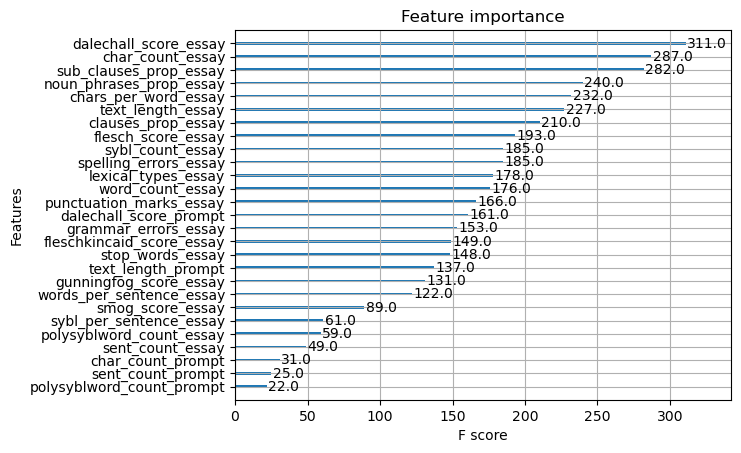

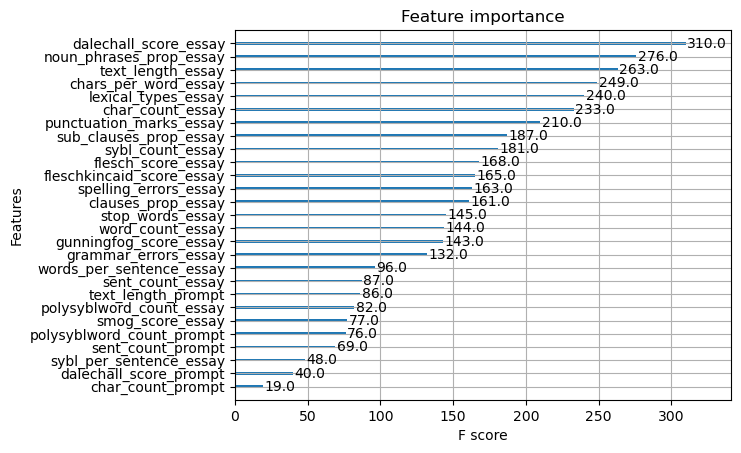

In [44]:
xgb.plot_importance(multi_xgb_model_1.estimators_[0])
plt.show()
xgb.plot_importance(multi_xgb_model_1.estimators_[1])
plt.show()

In [47]:
content_importances = multi_xgb_model_1.estimators_[0].get_booster().get_score(importance_type='weight')
wording_importances = multi_xgb_model_1.estimators_[1].get_booster().get_score(importance_type='weight')

features_to_keep = list(set(content_importances.keys()).union(set(wording_importances.keys())))

print("Total selected features:", len(features_to_keep))

xgb_model_2 = xgb.XGBRegressor(
    objective='reg:squarederror',
    seed=24,
    learning_rate=0.05,
    min_child_weight=100,
    max_depth=20,
    n_estimators=100
)

multi_xgb_model_2 = MultiOutputRegressor(xgb_model_2).fit(X_train_features, Y_train)

multi_xgb_model_2.fit(X_train_features[features_to_keep], Y_train)
predictions_xgb = multi_xgb_model_2.predict(X_val_features[features_to_keep])

Total selected features: 27


In [48]:
regression_report(Y_train['content'], multi_xgb_model_2.predict(X_train_features[features_to_keep])[:, 0], 'CONTENT TRAIN')
regression_report(Y_val['content'], predictions_xgb[:, 0], 'CONTENT TEST')

regression_report(Y_train['wording'], multi_xgb_model_2.predict(X_train_features[features_to_keep])[:, 1], 'WORDING TRAIN')
regression_report(Y_val['wording'], predictions_xgb[:, 1], 'WORDING TEST')

CONTENT TRAIN
std = 1.0487952988077796
rmse = 0.41417351227456867
r2 = 0.8440507904242517 

CONTENT TEST
std = 1.0220265405010216
rmse = 0.4760636979640112
r2 = 0.783026955087423 

WORDING TRAIN
std = 1.04289755999341
rmse = 0.5971698275397325
r2 = 0.672121899540815 

WORDING TEST
std = 1.0075341042027464
rmse = 0.6757782256621462
r2 = 0.5501280893819498 



## Deep Learning Model

In [49]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, concatenate, Dense
from tensorflow.keras.models import Model

In [50]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['prompt_text'] + X_train['prompt_question'] + X_train['text'])

max_sequence_length = 100
vocab_size = len(tokenizer.word_index) + 1  

sequences_prompt_texts = tokenizer.texts_to_sequences(X_train['prompt_text'])
sequences_prompt_questions = tokenizer.texts_to_sequences(X_train['prompt_question'])
sequences_texts = tokenizer.texts_to_sequences(X_train['text'])

padded_sequences_prompt_texts = pad_sequences(sequences_prompt_texts, maxlen=max_sequence_length)
padded_sequences_prompt_questions = pad_sequences(sequences_prompt_questions, maxlen=max_sequence_length)
padded_sequences_texts = pad_sequences(sequences_texts, maxlen=max_sequence_length)

# Define input layers
input_prompt_text = Input(shape=(max_sequence_length,))
input_prompt_question = Input(shape=(max_sequence_length,))
input_text = Input(shape=(max_sequence_length,))

# Shared embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=100)  # Adjust the output_dim as needed

# Apply embedding to inputs
embedded_prompt_text = embedding_layer(input_prompt_text)
embedded_prompt_question = embedding_layer(input_prompt_question)
embedded_text = embedding_layer(input_text)

# LSTM layers to process embeddings
lstm_layer = LSTM(units=64)

lstm_output_prompt_text = lstm_layer(embedded_prompt_text)
lstm_output_prompt_question = lstm_layer(embedded_prompt_question)
lstm_output_text = lstm_layer(embedded_text)

# Concatenate the LSTM outputs
merged_output = concatenate([lstm_output_prompt_text, lstm_output_prompt_question, lstm_output_text])

# Dense layer for the final prediction
dense_layer = Dense(units=2, activation='linear')
output = dense_layer(merged_output)

# Create the Siamese model
siamese_model = Model(inputs=[input_prompt_text, input_prompt_question, input_text], outputs=output)

# Compile the model (choose appropriate optimizer and loss based on your task)
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
siamese_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 100, 100)             1137600   ['input_4[0][0]',             
                                                                     'input_5[0][0]',       

In [52]:
siamese_model.fit(
    [X_train['prompt_text'], X_train['prompt_question'], X_train['text']], Y_train,
    epochs=40,
    batch_size=128,
    validation_data=([X_val['prompt_text'], X_val['prompt_question'], X_val['text']], Y_val),
)

Epoch 1/40


UnimplementedError: Graph execution error:

Detected at node model_1/Cast defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\osjom\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\osjom\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\osjom\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\osjom\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\osjom\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\osjom\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\osjom\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\osjom\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue

  File "C:\Users\osjom\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one

  File "C:\Users\osjom\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell

  File "C:\Users\osjom\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request

  File "C:\Users\osjom\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute

  File "C:\Users\osjom\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell

  File "C:\Users\osjom\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell

  File "C:\Users\osjom\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell

  File "C:\Users\osjom\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\osjom\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async

  File "C:\Users\osjom\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes

  File "C:\Users\osjom\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code

  File "C:\Users\osjom\AppData\Local\Temp\ipykernel_28988\3051102342.py", line 1, in <module>

  File "C:\Users\osjom\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\osjom\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1783, in fit

  File "C:\Users\osjom\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1377, in train_function

  File "C:\Users\osjom\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1360, in step_function

  File "C:\Users\osjom\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1349, in run_step

  File "C:\Users\osjom\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1126, in train_step

  File "C:\Users\osjom\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\osjom\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 589, in __call__

  File "C:\Users\osjom\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\osjom\anaconda3\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\osjom\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\osjom\anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "C:\Users\osjom\anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 654, in _run_internal_graph

  File "C:\Users\osjom\anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 751, in _conform_to_reference_input

Cast string to float is not supported
	 [[{{node model_1/Cast}}]] [Op:__inference_train_function_9785]